# VGG-19 Convolutional Neural Networks: CIFAR10 dataset

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU, BatchNormalization
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
tf.__version__

'2.2.0'

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [4]:
batch_size = 64
num_classes = 100
num_epochs = 145

In [5]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Load CIFAR-100 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (32, 32, 3)



In [7]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [8]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [9]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 100)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 100)


### Prepare CIFAR10 dataset for _GradientTape_ training:

In [10]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [11]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [12]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [13]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [14]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [31]:
def vgg19_dnn():
    model = Sequential()
    
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 3)
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.3))
    
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    
    model.add(
        Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
        Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    
    model.add(
        Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    
    model.add(
        Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    
    model.add(
        Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
        Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    
    model.add(
        Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    
    model.add(
        Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    
    model.add(
        Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
        Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    
    model.add(
        Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    
    model.add(
        Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    
    model.add(
        Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    
    '''
    model.add(
    AveragePooling2D(
        pool_size=(2, 2), strides=(2, 2)
    )
    )
    '''
    
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(Flatten())
    
    '''
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    '''
    
    
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.he_normal()
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.5))
    
    '''
    model.add(
    Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.he_normal()
        )
    )
    
    model.add(BatchNormalization())
    '''
    
    
    model.add(
        Dense(
            units = num_classes, activation='softmax'
        )
    )
    
    
    # Compile pruned CNN-
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        metrics=['accuracy']
    )
    
    return model
    
    

In [44]:
def vgg19_nn():
    """
    Function to define the architecture of a convolutional neural network
    model following VGG-19 architecture for CIFAR-10 dataset.
    
    Vgg-19 architecture-
    64, 64, pool                 -- convolutional layers
    128, 128, pool               -- convolutional layers
    256, 256, 256, 256, max-pool -- convolutional layers
    512, 512, 512, 512, max-pool -- convolutional layers
    512, 512, 512, 512, avg-pool -- convolutional layers
    10                           -- fully connected layers
    
    Output: Returns designed and compiled convolutional neural network model
    """

    
    # l = tf.keras.layers
    
    model = Sequential()
    
    model.add(
    Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 3)
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.3))
    
    model.add(
    Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.4))
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(BatchNormalization())
    
    
    model.add(
    # AveragePooling2D(
        MaxPooling2D(
            pool_size=(2, 2), strides=(2, 2)
        )
    )
    
    model.add(Flatten())
    
    model.add(
    Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.he_normal()
        )
    )
    
    model.add(BatchNormalization())
    
    # model.add(Dropout(0.4))
    '''
    model.add(
    Dense(
            units = 256, activation='relu',
            kernel_initializer = tf.initializers.he_normal()
        )
    )
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.4))
    '''
    
    model.add(
    Dense(
            units = num_classes, activation='softmax'
        )
    )
    
    
    # Compile pruned CNN-
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        metrics=['accuracy']
    )
    
    return model


In [17]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
'''
callback = [
             # sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]
'''

In [45]:
# Initialize a CNN model-
orig_model = vgg19_nn()
# orig_model = vgg19_dnn()

In [46]:
# Save random weights of defined CNN-
orig_model.save_weights("VGG19_Random_Weights.h5", overwrite=True)

In [ ]:
# Get CNN model summary-
orig_model.summary()

### Image Augmentation using _ImageDataGenerator_:

Refer-
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#fit

In [79]:
# Example of using 'tf.keras.preprocessing.image import ImageDataGenerator class's - flow(x, y)':
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range = 20,
    width_shift_range = 0.1, # 0.2
    height_shift_range = 0.1, # 0.2
    # horizontal_flip = True
)


# flow():
# Takes data & label arrays, generates batches of augmented data.

# datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
'''
for x, y in datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True):
	print(x.shape, y.shape)
'''

'\nfor x, y in datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True):\n\tprint(x.shape, y.shape)\n'

In [80]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [81]:
# Create mask using winning ticket-

# Instantiate a new neural network model for which, the mask is to be created,
mask_model = vgg19_nn()
    
# Load weights of PRUNED model-
mask_model.set_weights(orig_model.get_weights())
    
# For each layer, for each weight which is 0, leave it, as is.
# And for weights which survive the pruning,reinitialize it to ONE (1)-
for wts in mask_model.trainable_weights:
    wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))


In [82]:
# Count number of non-zero masks-
mask_params = 0

for layer in mask_model.trainable_weights:
    nonzeroparams = tf.math.count_nonzero(layer, axis = None).numpy()
    # print("layer: {0} has {1} non-zero masks".format(layer.shape, nonzeroparams))
    mask_params += nonzeroparams

print("\nTotal # of non-zero masks = {0}\n".format(mask_params))


Total # of non-zero masks = 20181311



### Python 3 dictionary to hold model training metrics for each of n rounds:

In [69]:
# Python3 dict to hold model metrics from each training epoch-
history = {}

# Initialize all epochs to zeros-
history['accuracy'] = np.zeros(shape = num_epochs)
history['val_accuracy'] = np.zeros(shape = num_epochs)
history['loss'] = np.zeros(shape = num_epochs)
history['val_loss'] = np.zeros(shape = num_epochs)

In [70]:
# Sanity check-
history.keys()

dict_keys(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

### Train model using _tf.GradientTape_:

In [74]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 3

In [75]:
best_val_loss = 100
loc_patience = 0

In [48]:
# best_trained_weights = []

In [76]:
# Initialize a new LeNet-300-100 model-
winning_ticket_model = vgg19_nn()

# Load weights of winning ticket-
winning_ticket_model.set_weights(orig_model.get_weights())

In [77]:
# Define 'train_one_step()' and 'test_step()' functions here-
@tf.function
def train_one_step(model, mask_model, optimizer, x, y):
    '''
    Function to compute one step of gradient descent optimization
    '''
    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_pred = model(x)

        # Compute loss-
        loss = loss_fn(y, y_pred)
        
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    for grad_layer, mask in zip(grads, mask_model.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

    # Compute accuracy-
    train_loss(loss)
    train_accuracy(y, y_pred)

    return None
    
    
@tf.function
def test_step(model, optimizer, data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

    return None



In [83]:
# Train model using 'GradientTape'-
    
# Initialize parameters for Early Stopping manual implementation-
# best_val_loss = 100
# loc_patience = 0
    
for epoch in range(num_epochs):
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
        
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    # variable to keep track of current training step-
    curr_step = 0
    
    # Train using data augmentation (ImageDataGenerator())-
    for x, y in datagen.flow(X_train, y_train, batch_size = batch_size, shuffle = True):
    # for x, y in zip(augmented_train_batches, y_train):
        train_one_step(winning_ticket_model, mask_model, optimizer, x, y)
        # print("current step = ", curr_step)
        curr_step += 1
        
        # break out of infinite loop to end current training epoch-
        if curr_step >= X_train.shape[0] // batch_size:
            # print("\nTerminating training (datagen.flow())")
            break

    # Testing dataset-
    for x_t, y_t in test_dataset:
    # for x_t, y_t in zip(validation_batches, y_test):
        test_step(winning_ticket_model, optimizer, x_t, y_t)
    
    '''
    for x, y in train_dataset:
        train_one_step(winning_ticket_model, mask_model, optimizer, x, y)

    for x_t, y_t in test_dataset:
        test_step(winning_ticket_model, optimizer, x_t, y_t)

    '''

    
    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
    
    
    # 'epoch' is the index for current training epoch-
    history['accuracy'][epoch] = train_accuracy.result() * 100
    history['loss'][epoch] = train_loss.result()
    history['val_loss'][epoch] = test_loss.result()
    history['val_accuracy'][epoch] = test_accuracy.result() * 100
    

    print(template.format(
        epoch + 1, train_loss.result(),
        train_accuracy.result() * 100, test_loss.result(),
        test_accuracy.result()  *100)
         )
    
    # Count number of non-zero parameters in each layer and in total-
    # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")
    model_sum_params = 0
    
    for layer in winning_ticket_model.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("Total number of trainable parameters = {0}\n".format(model_sum_params))
    
    '''
    # Manual implementation of code for early stopping-
    if test_loss.result() < best_val_loss:
        best_trained_weights = copy.deepcopy(winning_ticket_model.get_weights())
        print("\ntest_loss.result = {0:.4f}, best_val_loss = {1:.4f}, copied 'best weights'\n".format(test_loss.result(), best_val_loss))
    '''
    
    '''
    # Code for manual Early Stopping:
    if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = test_loss.result()
        
        # reset 'loc_patience' variable-
        loc_patience = 0
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    '''

Epoch 1, Loss: 4.4419, Accuracy: 2.1107, Test Loss: 4.2141, Test Accuracy: 3.520000
Total number of trainable parameters = 20181311

Epoch 2, Loss: 4.0936, Accuracy: 5.7058, Test Loss: 3.9415, Test Accuracy: 8.570000
Total number of trainable parameters = 20181311

Epoch 3, Loss: 3.8299, Accuracy: 10.0632, Test Loss: 3.6622, Test Accuracy: 12.250000
Total number of trainable parameters = 20181311

Epoch 4, Loss: 3.5971, Accuracy: 14.0965, Test Loss: 3.4395, Test Accuracy: 16.539999
Total number of trainable parameters = 20181311

Epoch 5, Loss: 3.4106, Accuracy: 17.3015, Test Loss: 3.2038, Test Accuracy: 21.170000
Total number of trainable parameters = 20181311

Epoch 6, Loss: 3.2020, Accuracy: 20.9287, Test Loss: 3.0018, Test Accuracy: 24.529999
Total number of trainable parameters = 20181311

Epoch 7, Loss: 3.0244, Accuracy: 24.4238, Test Loss: 3.0648, Test Accuracy: 24.799999
Total number of trainable parameters = 20181311

Epoch 8, Loss: 2.8608, Accuracy: 27.5608, Test Loss: 2.7702

### Visualization of training:

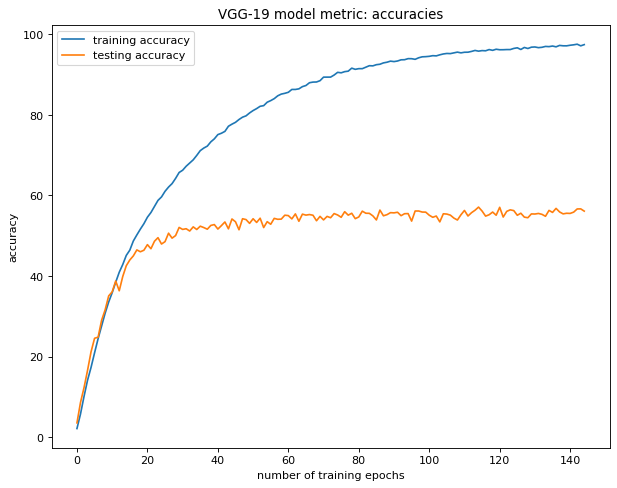

In [90]:
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history['accuracy'], label = 'training accuracy')
plt.plot(history['val_accuracy'], label = 'testing accuracy')

plt.title("VGG-19 model metric: accuracies")
plt.xlabel("number of training epochs")
plt.ylabel("accuracy")
plt.legend(loc = 'best')
plt.show()

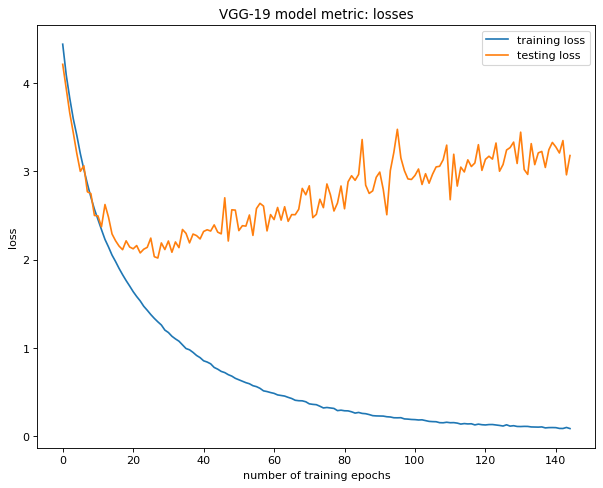

In [91]:
fig=plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history['loss'], label = 'training loss')
plt.plot(history['val_loss'], label = 'testing loss')

plt.title("VGG-19 model metric: losses")
plt.xlabel("number of training epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()

In [26]:
# Evaluate trained model on validation data-
loss, acc = winning_ticket_model.evaluate(X_test, y_test, verbose=0)

In [27]:
print("\nVGG-19 CNN (145 epochs training without early stopping) metrics on validation data:")
print("loss = {0:.4f} and accuracy = {1:.4f}%\n".format(loss, acc * 100))


VGG-19 CNN (145 epochs training without early stopping) metrics on validation data:
loss = 2.8174 and accuracy = 59.1800%



### Train model with .fit_generator() method:

In [67]:
# Initialize a VGG-19 Deep CNN-
model = vgg19_nn()

# Load weights using model from above-
model.set_weights(orig_model.get_weights())

In [ ]:
# Train model using data augmentation-
'''
history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size = batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = X_train.shape[0] // batch_size,
    epochs = num_epochs
)
'''

'''
# fits the model on batches with real-time data augmentation:
history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size = batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = len(X_train) // batch_size,
    epochs = num_epochs
)
'''

'''
# Might be WRONG, CHECK-

# A more "manual" example
for e in range(num_epochs):
    print("\nCurrent epoch = {0}".format(e))
    batches = 0
    for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size = batch_size):
        model.fit(x_batch, y_batch)
        batches += 1
        if batches >= len(X_train) / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
'''

In [28]:
# Train CNN using early stopping callback-
history = orig_model.fit(
        x = X_train, y = y_train,
        batch_size = batch_size,
        epochs = num_epochs,
        verbose = 1,
        callbacks = callback,
        validation_data = (X_test, y_test),
        shuffle = True
    )
    

Epoch 1/145
782/782 [==============================] - 79s 101ms/step - loss: 3.7013 - accuracy: 0.1341 - val_loss: 3.3331 - val_accuracy: 0.1959
Epoch 2/145
782/782 [==============================] - 44s 56ms/step - loss: 2.9167 - accuracy: 0.2651 - val_loss: 2.7362 - val_accuracy: 0.3099
Epoch 3/145
782/782 [==============================] - 45s 57ms/step - loss: 2.3784 - accuracy: 0.3725 - val_loss: 2.7275 - val_accuracy: 0.3301
Epoch 4/145
782/782 [==============================] - 45s 57ms/step - loss: 1.9774 - accuracy: 0.4612 - val_loss: 2.1823 - val_accuracy: 0.4310
Epoch 5/145
782/782 [==============================] - 45s 57ms/step - loss: 1.6434 - accuracy: 0.5371 - val_loss: 2.0752 - val_accuracy: 0.4577
Epoch 6/145
782/782 [==============================] - 45s 58ms/step - loss: 1.3508 - accuracy: 0.6075 - val_loss: 2.2561 - val_accuracy: 0.4472
Epoch 7/145
782/782 [==============================] - 45s 58ms/step - loss: 1.0824 - accuracy: 0.6759 - val_loss: 2.1432 - val_a

In [29]:
print("\nTraining completed of VGG-19 CNN on CIFAR-100 dataset\n")


Training completed of VGG-19 CNN on CIFAR-100 dataset



In [30]:
# Evaluate trained model on validation data-
loss, acc = orig_model.evaluate(X_test, y_test, verbose=0)

In [31]:
print("\nVGG-19 CNN metrics on validation data:")
print("loss = {0:.4f} and accuracy = {1:.4f}%\n".format(loss, acc * 100))


VGG-19 CNN metrics on validation data:
loss = 2.2816 and accuracy = 47.1700%



In [20]:
# Save trained weights-
# orig_model.save_weights("VGG19_EarlyStopping_Trained_Weights.h5", overwrite = True)
# orig_model.save_weights("VGG10_CIFAR100_EarlyStopping_Trained_Weights.h5", overwrite=True)

In [23]:
'''
# Save the trained CNN model as a 'SavedModel' format-

# Create a directory to save files to-
!mkdir -p vgg19_cnn_saved_model_dense_layers

orig_model.save('vgg19_cnn_saved_model_dense_layers//vgg19_early_stopping_model_dense_layers')
'''

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: vgg19_cnn_saved_model_dense_layers//vgg19_early_stopping_model_dense_layers/assets


In [27]:
import os, pickle

In [30]:
os.getcwd()

'/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources'

In [28]:
with open("/home/majumdar/The_Lottery_Ticket_Hypothesis-Resources/VGG_19_history_main_Early_Stopping.pkl", 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
# Load saved model (from before)-
saved_vgg19 = tf.keras.models.load_model('vgg19_cnn_saved_model/vgg19_early_stopping_model')

In [42]:
# Get loaded model summary-
# saved_vgg19.summary()

In [ ]:
# Evalaute loaded model on validataion data-
loss, acc = saved_vgg19.evaluate(X_test, y_test, verbose=0)

print("\nPre-trained VGG-19 CNN model metrics on validation data:")
print("loss = {0:.4f} & accuracy = {1:.4f}%\n".format(loss, acc * 100))

### Global Pruning for VGG-19 CNN:

_The Lottery Ticket Hypothesis_ states that for VGG-19 CNN instead of using a _layer-wise_ magnitude based pruning strategy, a __global__ magnitude based pruning strategy is used.

This means that for all of the approximately 20 million parameters, prune _p%_ of the smallest magnitude weights, irrespective of the conv layer the weight belongs to.

Possible approach to _global pruning_:

1. Store all prunable parameters to __one-dimensional__ numpy array using (x, y, z, a) reshaped to (x * y * z * a)
1. Prune _p%_ of smallest weight based magnitude from this __one-dimensional__ numpy array
1. Restore the pruned parameters for each conv layer following reverse of _step 1_

In [37]:
def prune_vgg19(model, pruning_params_conv):
    '''
    Inputs:

    'model' is the TensorFlow 2.0 defined convolutional neural network
    'pruning_params_conv' is the percentage of weights to prune for convolutional layer

    Returns:
    Python list containing pruned layers
    '''

    # Python 3 list to hold layer-wise weights-
    pruned_weights = []

    for layer in saved_vgg19.trainable_weights:
        x = layer.numpy()
        pruned_weights.append(x)

    # Flatten all numpy arrays-
    pruned_weights_flattened = [layer.flatten() for layer in pruned_weights]

    # Compute the smallest weights to prune based on 'p' parameter-
    p = 20  # 20% of smallest global weights to be pruned considering ALL conv layers

    threshold = np.percentile(abs(np.concatenate(pruned_weights_flattened)), pruning_params_conv)
    # print("\nFor p = {0:.2f}% of weights to be pruned, threshold = {1:.4f}\n".format(p, threshold))


    # np.concatenate(flattened).shape
    # (4032,)

    # Prune weights (set values to 0) when smaller than threshhold for CONV layers ONLY-
    for layer in pruned_weights:
        if len(layer.shape) == 4:
            layer[abs(layer) < threshold] = 0


    return pruned_weights

In [38]:
# Initialize a new VGG-19 CNN-
pruned_vgg = pruned_nn()

In [39]:
# Prune weights based on percentage of weights to prune-
pruned_weights = prune_vgg19(pruned_vgg, 20)

In [40]:
# Load Python 3 pruned weights as list-
pruned_vgg.set_weights(pruned_weights)

In [35]:
# Sanity check-
pruned_sum_params = 0
    
for layer in pruned_vgg.trainable_weights:
    # print(tf.math.count_nonzero(layer, axis = None).numpy())
    pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

    
print("\nTotal number of trainable parameters in pruned VGG-19 CNN = {0}\n".format(pruned_sum_params))


Total number of trainable parameters in pruned VGG-19 CNN = 16024868



In [41]:
16024868 - 16023611

1257